In [1]:
from zumi.zumi import Zumi
from zumi.util.screen import Screen
import time
from datetime import datetime
from zumi.util.vision import Vision
from zumi.util.camera import Camera 
from zumi.personality import Personality
import pandas as pd
import cv2

zumi =    Zumi()
camera    = Camera()
screen    = Screen()
vision    = Vision()
personality = Personality(zumi, screen)

Starting Zumi 
Pi Zero I2C is available
Verified Pi Zero is the same
Gyroscope previously calibrated
Zumi board detected
Compass detected
OLED Screen detected
Gyroscope & Accelerometer detected
Zumi battery level  57 %


In [31]:
zumi.get_battery_percent()

44

In [2]:
zumi.mpu.calibrate_MPU()

Creating new offset file...
.
.


In [ ]:
log = {}
def line_correction(bottom_left, bottom_right, desired_angle, threshold):
    if bottom_left > threshold and bottom_right < threshold:
        desired_angle +=5
    elif bottom_left < threshold and bottom_right > threshold:
        desired_angle -=5
    return desired_angle

def turning_correction(desired_angle, turn_angle):
    if desired_angle >= -turn_angle if desired_angle<0 else turn_angle:
        desired_angle = -abs(turn_angle-abs(desired_angle))
    else:
        desired_angle = abs(turn_angle-abs(desired_angle))
    return desired_angle

def turn_to_check(turn, angle = 90):
    zumi.reset_gyro()
    if turn == 'left':
        zumi.signal_left_on()
        zumi.turn_left(angle)
        zumi.signal_left_off()
    elif turn == 'right':
        zumi.signal_right_on()
        zumi.turn_right(2*angle)
        zumi.signal_right_off()
    time.sleep(0.01)
    desired_angle = zumi.read_z_angle()
    return desired_angle

def move_after_turning(speed, desired_angle):
    zumi.reset_gyro() 
    for x in range(3):
        zumi.go_straight(speed, desired_angle)

def object_detected(threshold=100):
    front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data() # Get center IR sensor value
    
    return front_right < threshold and front_left < threshold

def log_event(action):
    timestamp = datetime.now()
    log[action] = log.setdefault(action, [])
    log[action].append(timestamp)

def circle(turn, speed, number_of_objects, threshold):
    for j in range(number_of_objects):
        for i in range(4):
            zumi.reset_gyro()
            if turn == 'left':
                zumi.signal_left_on()
                zumi.turn_left(90)
                zumi.signal_left_off()
                log_event('move_left')
            elif turn == 'right':
                zumi.signal_right_on()
                zumi.turn_right(90)
                zumi.signal_right_off()
                log_event('move_right')
            desired_angle = zumi.read_z_angle()
            desired_angle = turning_correction(desired_angle, 90)
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            zumi.reset_gyro()
            while bottom_left > threshold or bottom_right > threshold:
                front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
                desired_angle = line_correction(bottom_left, bottom_right, desired_angle, threshold)
                zumi.go_straight(speed, desired_angle)

def dance_360(turn, times):
    if turn == 'left':
        for _ in range(times):
            zumi.reset_gyro()
            zumi.signal_left_on()
            angle_to_turn = 360
            while angle_to_turn > 10:
                zumi.turn_left(angle_to_turn)
                angle_to_turn = 360 - zumi.read_z_angle()
            zumi.signal_left_off()
            zumi.stop()
        return angle_to_turn
    elif turn == 'right':
        for _ in range(times):
            zumi.reset_gyro()
            zumi.signal_right_on()
            angle_to_turn = 360
            while angle_to_turn > 10:
                zumi.turn_right(angle_to_turn)
                angle_to_turn = 360 + zumi.read_z_angle()
            zumi.signal_right_off()
            zumi.stop()
        return angle_to_turn
    
def find_the_finish_line():
    speed = 20
    threshold = 100
    zumi.reset_gyro()

    turned_left_angle = turn_to_check('left', 70)
    

        # Calculate angle if turn was too much or not enough
    desired_angle = turning_correction(turned_left_angle, 55)

    front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
    time.sleep(0.1)
    if (bottom_left < threshold or bottom_right < threshold):
        print("no line left")
        turned_right_angle = turn_to_check('right', 70) 
                
        # Calculate angle if turn was too much or not enough
        desired_angle = turning_correction(turned_right_angle, 90)

        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()

    
def find_line(angle_to_turn):
    zumi.reset_gyro()
    speed = 20
    threshold = 100
    # Move if sitll on line
    
    while True:
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        zumi.go_straight(speed, angle_to_turn)
        if bottom_right < threshold and bottom_left < threshold:
            zumi.stop()
            break
    # Move to find new line
    while True:
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        zumi.go_straight(speed, angle_to_turn)
        if bottom_right > threshold and bottom_left > threshold:
            zumi.stop()
            break
    log_event("again_on_line")
    while True:
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        zumi.go_straight(speed, angle_to_turn)
        if bottom_right < threshold and bottom_left < threshold:
            zumi.stop()
            break
    log_event("out_of_line")
    if (log['out_of_line'][-1] - log['again_on_line'][-1]).total_seconds() < 1:
        while True:
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            zumi.go_straight(speed, angle_to_turn)
            if bottom_right > threshold and bottom_left > threshold:
                zumi.stop()
                break
        while True:
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            zumi.go_straight(speed, angle_to_turn)
            if bottom_right < threshold and bottom_left < threshold:
                zumi.stop()
                break
    elif (log['out_of_line'][-1] - log['again_on_line'][-1]).total_seconds() < 3:
        find_the_finish_line()



def face_detection():
    print("Taking picture...")
    camera.start_camera()
    for _ in range(10):
        captured_picture = camera.capture()
        gray_picture = vision.convert_to_gray(captured_picture) 
        # screen.show_image(captured_picture) #used to check whether the picture of the face was in frame of the captured picture
        faces= vision.find_face(gray_picture)
        print(faces)
        camera.show_image(captured_picture)
        if faces != None:
            print("Face detected!")
            break
    camera.close()
    if faces== None:
        screen.draw_text_center("No Face Detected!")
        # screen.show_image(captured_picture)
        cv2.imwrite("picture.png", gray_picture)
        # print("image1")
        camera.show_image(captured_picture)
        return False
    else:
        screen.draw_text_center("Face Detected!")
        zumi.play_note(40, 500)
        return True

                                        

def qr_code_command(message, speed, number_of_objects, threshold):
    print("QR code message: ", message)
    if message == "Left Circle":
        circle('left', speed, number_of_objects, threshold)
    elif message == "Right Circle":
        circle('right', speed, number_of_objects, threshold)
    elif message == "Turn Left":
        zumi.signal_left_on()
        zumi.turn_left(90)
        zumi.signal_left_off()
    elif message == "Turn Right":
        zumi.signal_right_on()
        zumi.turn_right(90)
        zumi.signal_right_off()
    elif message == "Stop":
        zumi.stop()
    elif message == "Zumi is happy today!":
        personality.happy()
    elif message == "Zumi is angry today!":
        personality.angry()
    elif message == "Zumi is celebrating today!":
        personality.celebrate()
    elif "360" in str(message):

        spin_message = message.split(" ")
        times = int(spin_message[0])
        turn = spin_message[3][:-1]
        emotion = spin_message[-1]

        print("turn", turn)
        angle_to_turn = dance_360(turn, times)*2

        if emotion == "happy":
            personality.happy()
        elif emotion == "angry":
            personality.angry()
        elif emotion == "celebrate":
            personality.celebrate()
        zumi.stop()
        
        print("Angle to turn: ", angle_to_turn)
        find_line(angle_to_turn)
        
    


        
    else:
        print("Invalid command")
        return "Invalid command"

def read_qr_code(speed, number_of_objects, threshold):
    camera.start_camera()
    for _ in range(10):
        frame = camera.capture()
        camera.show_image(frame)
        qr_code = vision.find_QR_code(frame)
        message = vision.get_QR_message(qr_code)
        if message != None:
            break
    camera.close()
    qr_code_command(message, speed, number_of_objects, threshold)
    return message

def move_after_turning(speed, desired_angle):
    zumi.reset_gyro() 
    for x in range(3):
        zumi.go_straight(speed, desired_angle)

def finish_with_180_turn():
    zumi.stop()
    log_event("finish")
    print("Reached end. Performing 180° turn.")
    screen.draw_text_center("Finisher box\nTurning 180°")
    zumi.turn_left(180)
    screen.draw_text_center("Done!")

def save_dict_to_csv(data_dict):
    # Generate file name with current time
    current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
    file_name = "Zumi7337_output_" + current_time + ".csv"

    # Create empty list to store rows
    rows = []

    # Go through all actions and timestamps
    for action, timestamps in data_dict.items():
        for timestamp in timestamps:
            # Add row to list of rows
            rows.append({"timestamp": timestamp, "action": action})

    # Create DataFrame from list of rows
    df = pd.DataFrame(rows)

    # Sort DataFrame by column timestamp
    df = df.sort_values(by='timestamp')

    # Save DataFrame in CSV file
    df.to_csv(file_name, index=False)
    print("Data saved in ", file_name)

In [42]:
front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
bottom_right, bottom_left

(13, 12)

In [33]:
find_line(-3)

IndexError: list index out of range

In [21]:
personality.celebrate()

Waiting for object to be removed...
Object removed. Resuming movement.
Starting PiCamera


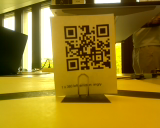

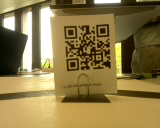

Closing PiCamera
QR code message:  1 x 360 left, emotion: angry
turn left
Angle to turn:  -3.0720000000000027
Reached end. Performing 180° turn.


In [25]:
log = {}
zumi.reset_gyro()
desired_angle = zumi.read_z_angle() 
number_of_objects = 0
number_of_faces = 0

log_event('start')
log_event('end_line')

try:
    while True:
        # Set the threshold for the IR sensors and the speed
        threshold = 50 
        speed = 5

        if object_detected():
            zumi.stop()
            while object_detected():
                zumi.stop()
                time.sleep(0.1)
                
            zumi.brake_lights_on()
            time.sleep(0.5)
            zumi.brake_lights_off()
            log_event('object_detected')
            number_of_objects += 1
            zumi.play_note(1, 500) # 1 is note type (1 - 60), 500 is duration in ms
            screen.draw_text_center("Objects: " + str(number_of_objects)) # Display object count on screen
            # Wait until the object is removed
            print("Waiting for object to be removed...")

            log_event('object_removed')
            print("Object removed. Resuming movement.")
            log_event('loking for qr_code of face')

            message = read_qr_code(speed, number_of_objects, threshold)

            if message == None: # If Zumi sees (and can read) a QR code it will do what ever the code tells it to
                screen.draw_text_center("I see no QR code")
                time.sleep(1)
                if face_detection():
                    number_of_faces += 1
                    zumi.play_note(13, 500) # 13 is note type (1 - 60), 500 is duration in ms
                    screen.draw_text_center("Faces: " + str(number_of_faces)) # Display object count on screen
                    print("Face detected")
            else:
                log_event('qr_code_command: ' + str(message) + " done")
            

        # Read all IR sensor values
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()

        # Correction to line if one sensor is on the line and the other is off
        desired_angle = line_correction(bottom_left, bottom_right, desired_angle, threshold)

        # Move forward with the corrected heading
        if bottom_left > threshold or bottom_right > threshold:
            zumi.go_straight(speed, desired_angle)
        else:
            log_event('end_line')
            
            if (log['end_line'][-1] - log['end_line'][-2]).total_seconds() > 3:
                go_left = True
            
                log_event('check_left')
                # Turn to check if left is line
                turned_left_angle = turn_to_check('left')

                # Calculate angle if turn was too much or not enough
                desired_angle = turning_correction(turned_left_angle, 90)

                front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            else:
                go_left = False
            if (bottom_left > threshold or bottom_right > threshold) and go_left:
                log_event('move_left')
                move_after_turning(speed, desired_angle)
            else:
                
                log_event('check_right')
                # Turn to check if right is line
                turned_right_angle = turn_to_check('right') 
                
                # Calculate angle if turn was too much or not enough
                desired_angle = turning_correction(turned_right_angle, 180)

                front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()

                if bottom_left > threshold or bottom_right > threshold:
                    log_event('move_right')
                    move_after_turning(speed, desired_angle)
                else:
                    zumi.stop()
                    log_event('stop')
                    finish_with_180_turn()
                    log_event('finish_with_180_turn')
                    break
finally:
    zumi.stop()
    log_event('stop')
    #save_dict_to_csv(log)